In [85]:
# # we will follow the pytorch documentation at : https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
# and we might use some of the classes from our implementation of a vision transformer

In [86]:
import numpy as np , pandas as pd
import torch
import torch.nn as nn

import torchvision.transforms as transforms
import torch.utils as utils

import matplotlib.pyplot as plt

In [87]:
fer = pd.read_csv("./archive/fer2013/fer2013/fer2013.csv")
fer[:2] # show first 2 examples

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training


In [88]:
fer_train = fer[fer.Usage == "Training"]
fer_valid = fer[fer.Usage == "PublicTest"]
fer_test = fer[fer.Usage == "PrivateTest"]

fer_train.shape ,fer_valid.shape, fer_test.shape

((28709, 3), (3589, 3), (3589, 3))

In [89]:
# from vit: without the patches
class FerDataset(utils.data.Dataset):
    """
    Keep the validation
    and test set seperate for now.
    Dont plan to use early stopping.
    just to make sure we are not leaking into validation Dataset
    """

    def __init__(self,df,label = None, transformations = None):
        super().__init__()
        if label not in ("train", "test", "valid"):
            raise ValueError("Please give al label to this dataset class train , valid , test")

        # handy stuff that i often call
        self.label = label

        self.data = df[df.columns[:-1]] # the last column is just usage
        self.columns = self.data.columns
        self.shape = self.data.shape
        self.transforms = transformations

        if self.transforms is None:
            self.transforms = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((32,32), antialias=True)]) # limit number of patches (4) calculation.. keep this a multiple of 16*16

    # mandatory method to calculate random indexes when you turn on shuffle in dataloader
    def __len__(self):
        return self.shape[0]


    def __getitem__(self, idx):
        # convert to string type

        self.data = self.data.astype({"emotion": int, "pixels": str})

        features = self.data.iloc[idx]['pixels']
        features = np.array(features.split(" "),dtype=np.uint8) # its a flatten of 48 * 48 * 1 image
        # image = features.view(48,48) -> numpy view is like astype with view not like torch.view
        image = features.reshape(48,48)
        if self.transforms:
            image = self.transforms(image)


        label = self.data.iloc[idx]['emotion']


        return image, label # dont use capital Tensor it will convert it into float

    @staticmethod
    def imshow(img):
        plt.figure(figsize=(5,5))
        img = torch.einsum("bhw -> hw",img) # squeeze out the batch dimension
        plt.imshow(img, cmap="gray")
        plt.axis("off")

        plt.show()


In [90]:
fer = FerDataset(fer_train, "train")
img,lab = fer[0]

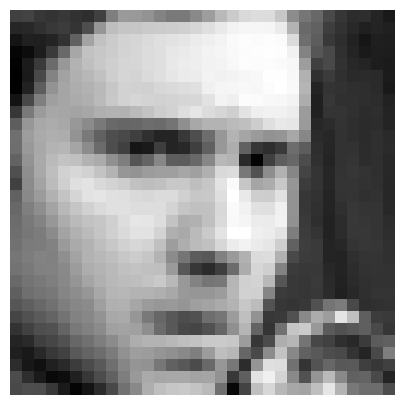

In [91]:
fer.imshow(img)

In [92]:
train_data = FerDataset(fer_train,"train")
train_loader = utils.data.DataLoader(train_data, shuffle=True, batch_size=32)

In [93]:
for data in train_loader:
    img, label = data
    print(img.shape, label)
    break

torch.Size([32, 1, 32, 32]) tensor([0, 4, 3, 3, 2, 5, 3, 4, 4, 5, 2, 5, 2, 4, 3, 1, 6, 6, 2, 2, 0, 0, 0, 4,
        4, 4, 4, 3, 5, 6, 3, 2])


In [94]:
# define a small convolutional network
# see beautiful mnist in tinygrad .
import torch.nn as nn
import torch.nn.functional as F

# shape after operations n,n ->(with padding p and stride s) (n + 2p - f + 1 )/s + 1

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5) 
        self.pool = nn.MaxPool2d(2, 2) # this is not a learnable operaation just performs downsampling
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 7) # we have 7 classes 

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        logits = self.fc3(x)
        return logits


net = Net()

In [95]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.AdamW(net.parameters(),lr=1e-3)

In [96]:
track_loss = list()

In [97]:
from tqdm import tqdm
for epoch in range(100):  # loop over the dataset multiple times
    for data in tqdm(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        track_loss.append(loss.item())
        loss.backward()
        optimizer.step()
    print(loss.item())



print('Finished Training')

100%|██████████| 898/898 [00:46<00:00, 19.27it/s]


1.8434803485870361


100%|██████████| 898/898 [00:44<00:00, 20.05it/s]


1.496429443359375


100%|██████████| 898/898 [00:44<00:00, 20.23it/s]


0.8707904815673828


100%|██████████| 898/898 [00:44<00:00, 20.14it/s]


1.374583125114441


100%|██████████| 898/898 [00:46<00:00, 19.44it/s]


1.214328408241272


100%|██████████| 898/898 [00:51<00:00, 17.41it/s]


0.6992374658584595


100%|██████████| 898/898 [00:58<00:00, 15.31it/s]


1.5476256608963013


 45%|████▌     | 406/898 [00:27<00:33, 14.68it/s]


KeyboardInterrupt: 

In [98]:
np.log(1/7)

-1.9459101490553135

In [99]:
loss.item()

1.3972270488739014

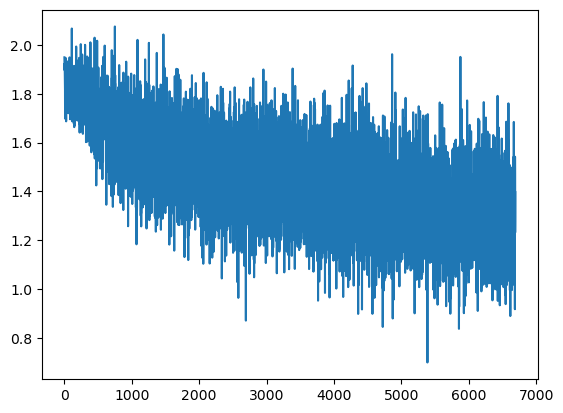

In [100]:
plt.plot(track_loss)